# DC Electrical Network Solved with a Diffusive Network Formulation

## Introduction

In this tutorial we solve a **DC electrical circuit** using the same **network-based diffusive formulation** previously used for fluid flow problems.

Although the physical interpretation is different, the **mathematical structure is identical**:

* Electrical networks
* Hydraulic networks
* Thermal diffusion
* 1D structural bars

are all governed by **linear conservation laws** that lead to the same assembled system:

$$
\mathbf{K}\mathbf{x} = \mathbf{b}
$$

This example is extracted from:

* Moaveni, S. (2011). *Finite Element Analysis: Theory and Application with ANSYS*.
* Problems 15–16 (DC electrical circuits)

<img src="images/electric.svg" width="400">

---

## 1. Physical–mathematical equivalence

| Electrical circuit    | Diffusive network      |
| --------------------- | ---------------------- |
| Voltage $V$           | Potential / head $x$   |
| Current $I$           | Nodal flow $b$         |
| Resistance $R$        | $1/k$                  |
| Conductance $G = 1/R$ | `element_property = k` |
| Ohm’s law             | Diffusive flux         |

---

## 2. Element formulation (Ohm’s law)

For a resistor connecting nodes $i$ and $j$:

$$
V_j - V_i = R I
$$

or equivalently:

$$
I = \frac{1}{R}(V_j - V_i)
$$

The elemental matrix form is:

$$
\begin{bmatrix}
I_i \\
I_j
\end{bmatrix}
= \frac{1}{R}
\begin{bmatrix}
1 & -1 \\
-1 &  1
\end{bmatrix}
\begin{bmatrix}
V_i \\
V_j
\end{bmatrix}
$$

This is **exactly the same matrix** used for a 1D diffusive element, with:

$$
k = \frac{1}{R}
$$

---

## 3. Circuit description

The circuit contains:

* A **current source** of $10,\text{mA}$
* Three resistors:

  * $5 \Omega$
  * $10 \Omega$
  * $15 \Omega$
* One node connected to **ground** (reference voltage)

---

## 4. Network definition

### 4.1 Connectivity

Each resistor is represented as a network element:

In [1]:
import numpy as np
from netsystems import Network, System, solve_linear_system, get_global_matrix_csr, spy_matrix

net = Network()

connectivity = np.array([
    [1, 2],  # 5 ohm resistor
    [2, 0],  # 10 ohm resistor
    [2, 0],  # 15 ohm resistor
])

net.set_connectivity(connectivity)

Each row defines a **two-node resistor**.

---

## 5. Electrical system as a diffusive system

In [2]:
electric = System("electric", system_type="diffusive")

electric.x_name = "voltage"        # Nodal voltage
electric.b_name = "current"        # Nodal current
electric.element_variable_name = "branch_current"

## 6. Boundary conditions

### 6.1 Known voltage (ground)

The reference node is fixed at zero voltage:

In [3]:
electric.known_x_nodes = np.array([0])
electric.known_x_values = np.array([0.0])

### 6.2 Current source

A current of $10,\text{mA}$ is injected at node 1:


In [4]:
electric.known_b_nodes = np.array([1])
electric.known_b_values = np.array([0.01])  # 10 mA

Positive sign means **current entering the node**.

---

## 7. Element properties: conductance

Resistances:

In [5]:
R = np.array([5.0, 10.0, 15.0])  # ohms

Conductance is the inverse:

$$
k = \frac{1}{R}
$$

In [7]:
electric.element_conductance = 1.0 / R

## 8. Solve the system

In [8]:
net.add_system(electric)

solve_linear_system(net, "electric")

0

## 9. Extracting results

### 9.1 Nodal voltages

In [9]:
net.get("voltage")

array([0.  , 0.11, 0.06])

This returns:

$$
\mathbf{V} =
\begin{bmatrix}
V_0 \
V_1 \
V_2
\end{bmatrix}
$$

### 9.2 Branch currents

In [10]:
net.get("branch_current")

array([0.01 , 0.006, 0.004])

Each entry corresponds to one resistor in the `connectivity` array.

---

### 9.3 Nodal current balance

In [11]:
net.get("current")

array([-0.01,  0.01,  0.  ])

In [12]:
K = get_global_matrix_csr(net, "electric")
print(K.todense())

[[ 0.16666667  0.         -0.16666667]
 [ 0.          0.2        -0.2       ]
 [-0.16666667 -0.2         0.36666667]]


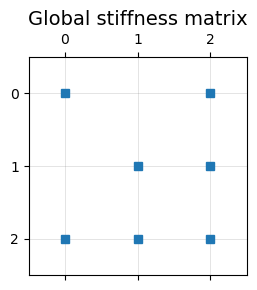

(<Figure size 300x300 with 1 Axes>,
 <Axes: title={'center': 'Global stiffness matrix'}>)

In [13]:
spy_matrix(
    K,
    title="Global stiffness matrix",
    markersize=6,
    figsize=(3, 3)
)